# Using Insitu Data with FluxEngine #

## Introduction
This script details how to visualise collected data and apply the FluxEngine functionalities to calculate air-sea gas flux

### Load Relevant Modules
To begin with the required Python packages are loaded (note: these are required to be installed in your environment first, else an error with appear). Also this is a good time to ensure you are running this script in the same environment where you have installed FluxEngine.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
# Install basemap-data-hires

### Loading the insitu data
Now we load the insitu data. This is very simple using the Pandas library where we can use the .read_csv() function, which can load CSV (Comma Seperated Values) or TSV (Tab Seperated Values) files. If you're using a CSV file the the 'sep' keyword should be changed to ',' but if using a TSV file then you can keep the sep='\t'. Additionally, the 'index_col' keyword is set to 0 to define that the first column in the data is simply indexing/counting the rows (i.e it's not actual data). You can try removing this with the example data to see what happens (it may help if for some reason your data does not include and index column).

Change the input file to either 'Carrick_Roads.tsv' or 'Agulhas.tsv' to load the example data, or input your own data file. We then show the first 5 rows of the data using the .head() function (and you can see the bottom 5 rows by changing this to .tail())

In [2]:
# Load data file
region_data = pd.read_csv('CC1611002_20180320_125039.csv', sep=',', index_col=0)
# Show small proportion of the data
region_data.head(5)

,Lon,Lat,Temperature,Salinity,Depth
0,-5.023148,50.146601,7.414918,34.469402,0.148883
1,-5.023148,50.146601,7.416624,34.167730,0.446668
2,-5.023148,50.146601,7.421356,34.447564,0.744460
3,-5.023148,50.146601,7.427272,34.433538,1.042222
4,-5.023148,50.146601,7.434272,34.437765,1.339985


### Plotting the Time Series  

The Matplotlib .subplots() function is ideal for this and I have used Seaborn to do the actual plotting - these two packages work well together as Seaborn is built on top of Matplotlib, and Seaborn also integrates easily with Pandas Dataframes. 

Producing nice looking plots with lovely axes labels and colors etc. can be fiddly, but you can refer to the documentation (and StackOverflow!) for hints and tips.

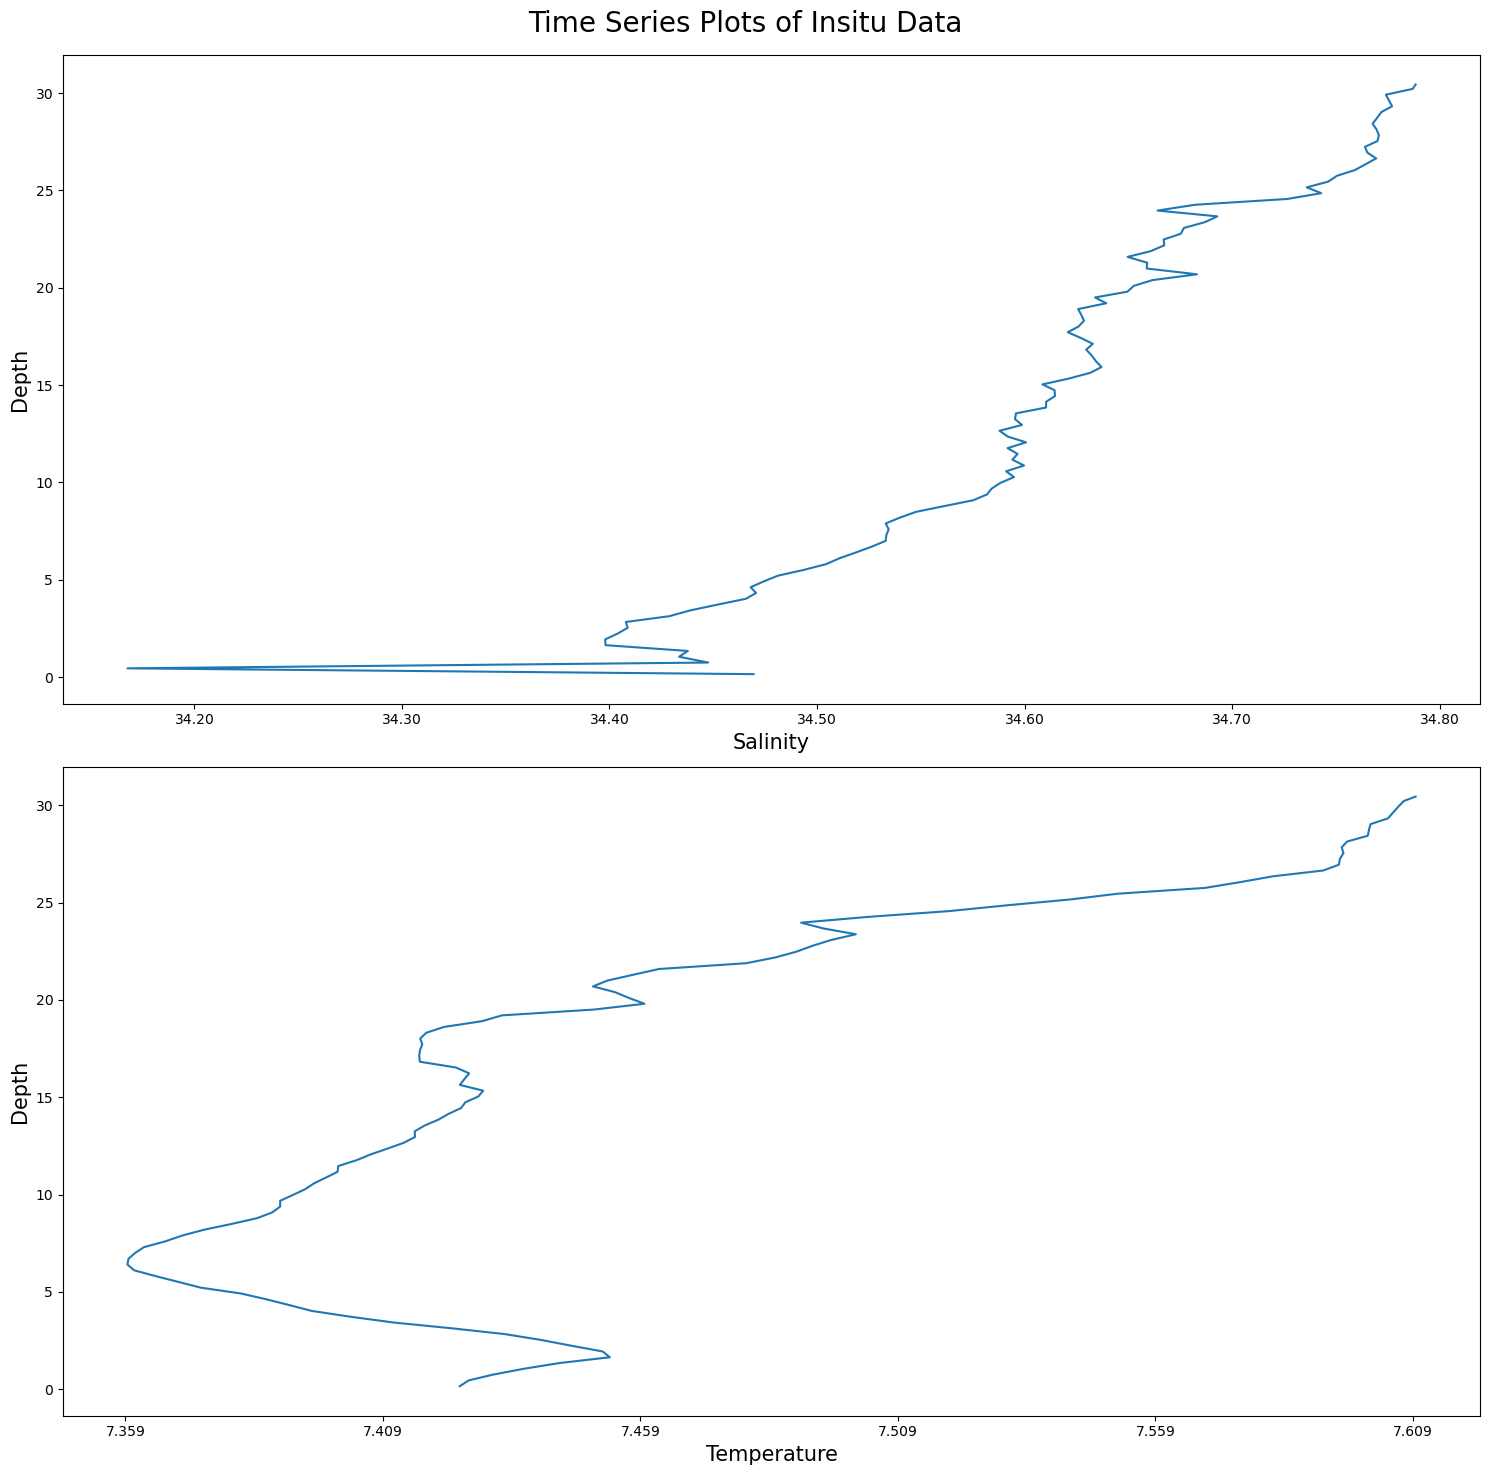

In [3]:
# Set up a figure with 4 axes on it. Sharex=True means all axes will share the bottom axes (can help with clarity)
fig,ax = plt.subplots(2,1, sharex=False)
# Set figure height and width
fig.set_figheight(15), fig.set_figwidth(15)
# Set overall title of subplots
fig.suptitle('Time Series Plots of Insitu Data', fontsize=20)

### PLOTTING THE DATA ### (- *s indicate a plot keyword below)
# These Seaborn commands state that we want a *lineplot*, where the *data* is coming 
# from our region_data Dataframe, and we chose the *x* & *y* columns that we want, as well
# as the axis (*ax*) we want to plot on (indexed by 0 at the top and 3 at the bottom)
sns.lineplot(data=region_data, x='Salinity', y='Depth', ax=ax[0], sort=False)
sns.lineplot(data=region_data, x='Temperature', y='Depth', ax=ax[1], sort=False)
#sns.lineplot(data=region_data, x='Days_since', y='xCO2air', ax=ax[2])
#sns.lineplot(data=region_data, x='Days_since', y='fCO2', ax=ax[3])

# Set y axis label
ax[0].set_ylabel('Depth', fontsize = 15) 
ax[1].set_ylabel('Depth', fontsize = 15)
# Set x label for each axis
ax[0].set_xlabel('Salinity', fontsize = 15) 
ax[1].set_xlabel('Temperature', fontsize = 15)
#ax[2].set_ylabel('xCO2 (1e-6 atm/mol)', fontsize = 20)
#ax[3].set_ylabel('fCO2 (1e-6 atm)', fontsize = 20)

# Changes how axis ticks are displayed for last two axes
# - you can comment these out with # to see the effect when removed
ax[0].xaxis.set_major_formatter('{x:9<5.2f}')
ax[1].xaxis.set_major_formatter('{x:9<5.2f}')
#ax[2].yaxis.set_major_formatter('{x:9<5.2f}')
#ax[3].yaxis.set_major_formatter('{x:9<5.2f}')

# Set a tight layout to remove extra space around the plots
fig.tight_layout()
# Reduce gap between top of figure and the title
fig.subplots_adjust(top=0.95)

# Show figure!
plt.show()

### Alkalinity

Here we can estimate the alkalinty by using a linear equation containing salinity:

$ Alkalinity = 889 + (37.9 X Salinity)$

In [4]:
# Create new columns in dataframe for alkalinity
region_data['alkalinity'] = 889 + 37.9*(region_data['Salinity']) 

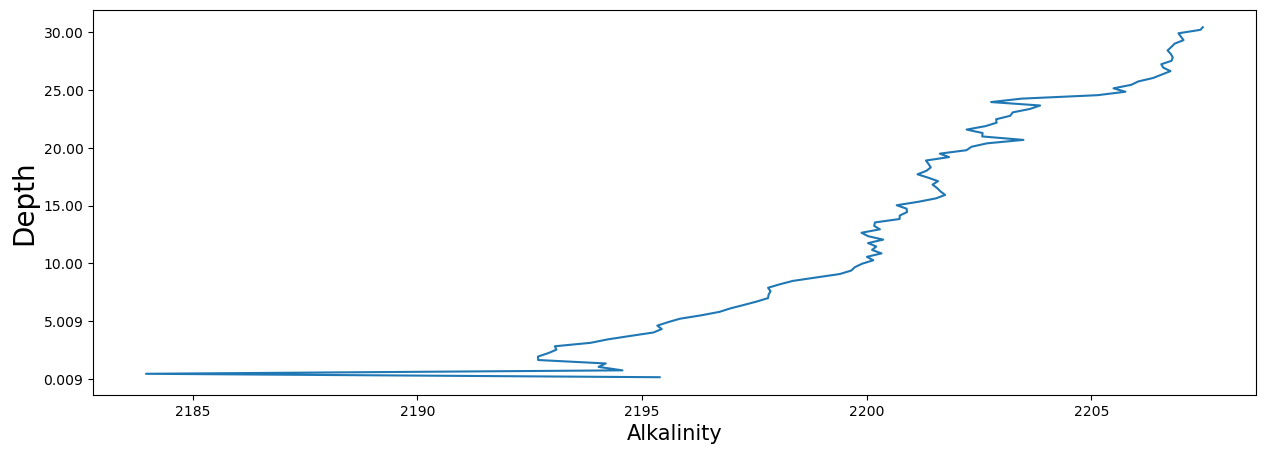

In [5]:
# Plot alaklinity - uses same commands as above but as only one plot is required we don't need to index the axes
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.lineplot(data=region_data, y='Depth', x='alkalinity', ax=ax, sort=False)
plt.xlabel(f'Alkalinity', fontdict={'size':15})
ax.set_ylabel('Depth', fontsize = 20) 
ax.yaxis.set_major_formatter('{x:9<5.2f}')
plt.show()

### Displaying Data on a Map

Now we aim to display the recorded data on a map. There are a couple of Python packages to do this but this script used Basemap (which is part of Matplotlib - although needs to be installed additionally) due to it having a decent spatial resolution. Note: if you're familar with GIS and producing Shapefiles you could attempt to use Geopandas, but it would require additional work.

First we can aquire the min/max longitude and latitude for our data to give us an idea of the region to plot.

In [6]:
# Get min and max of longitude and latitude
region_data.describe().loc[['min','max'],['Lon','Lat']]

,Lon,Lat
min,-5.023148,50.146601
max,-5.023148,50.146601


The fuction below has been written to allow easy plotting of the example datasets but also enable you to plot your own. Run the cell below to initalise the function (i.e nothing will happen)

In [7]:
def get_coords(location):
    if location == 'CC1611002_20180320_125039':
        lon_min = -5.2
        lon_max = -4.9
        lat_min = 50.1
        lat_max = 50.25
        return lon_min, lon_max, lat_min, lat_max
    
    elif location == 'Agulhas':
        lon_min = 19.7
        lon_max = 20.2
        lat_min = -35.0
        lat_max = -34.7
        return lon_min, lon_max, lat_min, lat_max
    
    else:
        lon_min = input('Enter minimum longitude (most Westerly): ')
        lon_max = input('Enter minimum longitude (most Easterly): ')
        lat_min = input('Enter minimum latitude (most Southerly): ')
        lat_max = input('Enter maximum latitude (most Northerly): ')
        print('\n\n')
        if (lon_min >= lon_max) or (lat_min >= lat_max):
            print('Check if min/max were entered in the correct order (is a min greater than a max?)')
            return np.nan, np.nan, np.nan, np.nan
        
        
        return float(lon_min), float(lon_max), float(lat_min), float(lat_max)

In the cell below you can change the string in the get_coords() function. Changing it to 'Carrick Roads' or 'Agulhus' will assign the min/max latitude & longtudes to those needed for plotting these regions (you can also enter 'World' but it's there purely to play with map projections if you wish). Alternatively you can enter 'Other', in which case text boxes will appear for you to enter the min/max longitudes and latitudes for your data.

In [8]:
### Change string to 'CarrickRoads', 'Agulhas' or your own region name (use '_' for spaces)
region_name = 'CC1611002_20180320_125039'
# Performs function
lon_min, lon_max, lat_min, lat_max = get_coords(region_name)

# Note: if you're having problems with the input fields you can uncomment the line below 
# and  just enter the values instead, but also comment out the line above to avoid confusion.

# lon_min, lon_max, lat_min, lat_max = __ , __ , __ , __

# Print out current values
print('Current values:')
print(f'Longitude -> \t min:{lon_min} \t max:{lon_max}')
print(f'Latitude -> \t min:{lat_min} \t max:{lat_max}')

Current values:
Longitude -> 	 min:-5.2 	 max:-4.9
Latitude -> 	 min:50.1 	 max:50.25


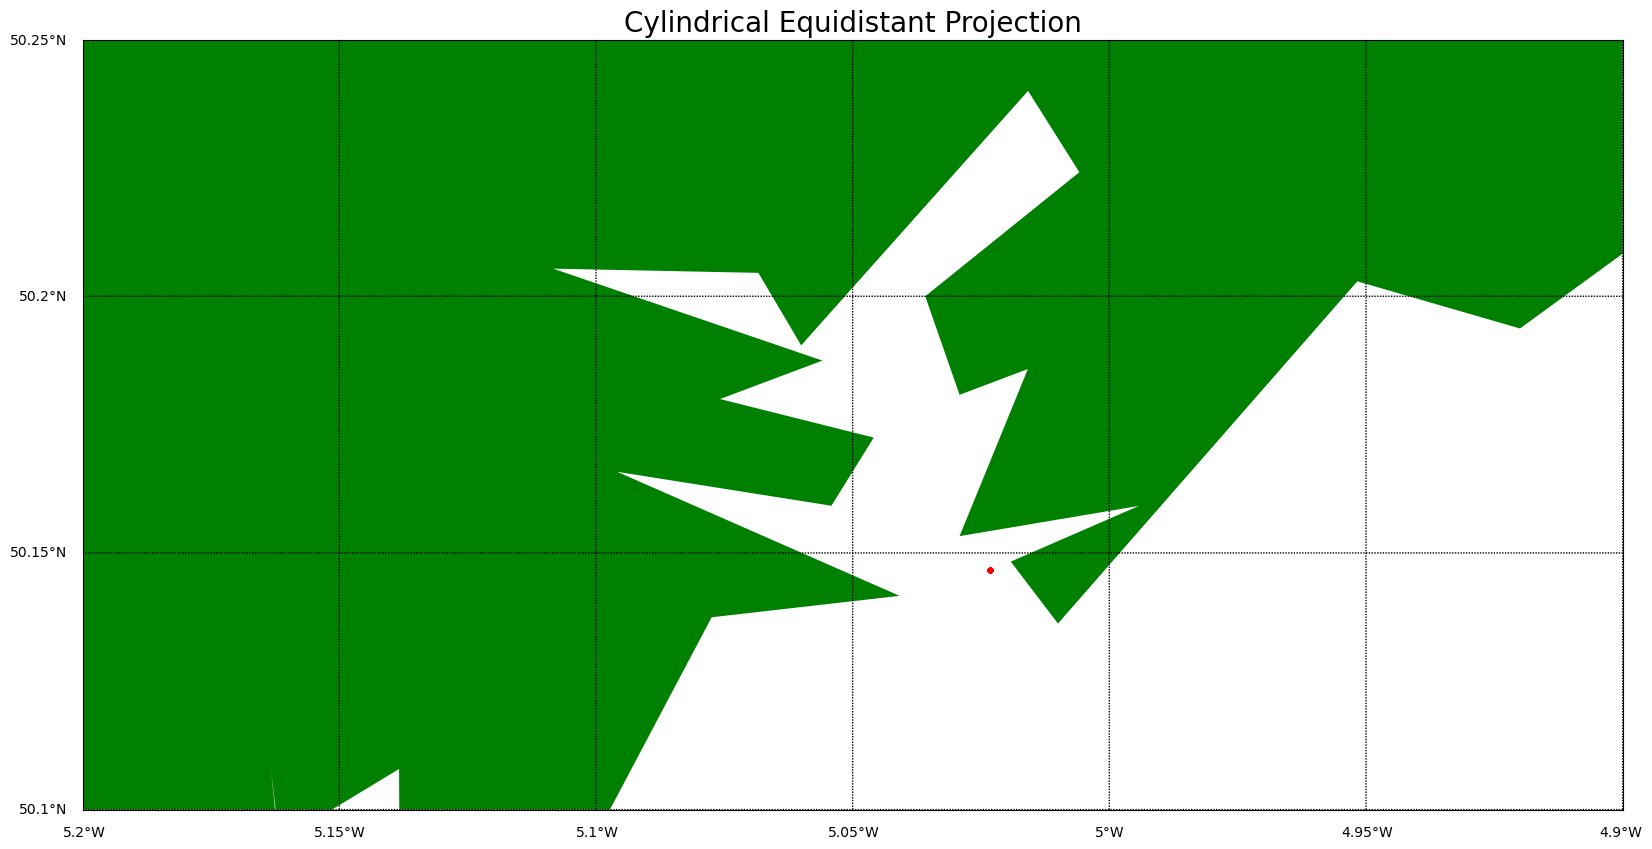

In [9]:
# 1) Intialise figure and figure size
fig = plt.gcf()
fig.set_size_inches(20,10, forward=True)

# 2) Define the map 
# Here we have a cylindrical equidistant projection bound by our chosen latitude and longitudes,
# and a chosen resolution ('i' = intermediate)
m = Basemap(projection='cyl',
            llcrnrlat=lat_min,urcrnrlat=lat_max,
            llcrnrlon=lon_min,urcrnrlon=lon_max,
            resolution='i')

# 3) Fill land masses with green colour
m.fillcontinents(color='green')
# Add title to plot - change as you wish
plt.title("Cylindrical Equidistant Projection", fontsize=20)

# 4) Draw map gridlines - the 'split_lat' and 'split_lon' have been set to show a 0.05x0.05 degree 
# grid, which reflects that given in the ESA CCI data (covered next)
split_lon = round((lon_max - lon_min)/0.05) + 1
lons = np.linspace(lon_min,lon_max,split_lon)
m.drawmeridians(lons,labels=[1,0,0,1])

split_lat = round((lat_max - lat_min)/0.05) + 1
lats = np.linspace(lat_min,lat_max,split_lat)
m.drawparallels(lats,labels=[1,0,0,1])


track_lon, track_lat = m(np.asarray(region_data['Lon']),np.asarray(region_data['Lat']))
plt.scatter(track_lon,track_lat, s=10, marker='o', color='Red') 


plt.show()